In [1]:
import scipy.stats as ss
from matplotlib import pyplot as plt
plt.style.use('bmh')
from matplotlib.gridspec import GridSpec as gs
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import make_pipeline

from tensorflow.keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#### Mark generator function

In [5]:
test_type = tuple(input("Enter the types of tests (seperated by a space): ").split()) # type of evaluations
test_amount = tuple(int(input(f"How many tests for {x}?: ")) for x in test_type) # amount of tests per evaluation
max_mark = tuple(int(input(f"{x} out of how many marks?: ")) for x in test_type) # maximum marks for each type of tests

while True:
    weightage = tuple(float(input(f"What is the weightage for {x}?: "))/100 for x in test_type)
    if np.sum(weightage) == 1.0:
        break
    else:
        print("Make sure the weightage for all tests add up to 1.0!\n")
pass_percent = float(input("What is the passing percentage threshold?: "))/100

while True:
    final_test_name = input(f"Which of these tests {test_type} is the final test?: ")
    if final_test_name in test_type:
        break
    else:
        print("Make sure the name of the final test is enterred correctly!\n")

Enter the types of tests (seperated by a space): Lab Assignment Mid-Term Project Final
How many tests for Lab?: 8
How many tests for Assignment?: 4
How many tests for Mid-Term?: 1
How many tests for Project?: 1
How many tests for Final?: 1
Lab out of how many marks?: 10
Assignment out of how many marks?: 30
Mid-Term out of how many marks?: 30
Project out of how many marks?: 30
Final out of how many marks?: 30
What is the weightage for Lab?: 20
What is the weightage for Assignment?: 10
What is the weightage for Mid-Term?: 10
What is the weightage for Project?: 40
What is the weightage for Final?: 20
What is the passing percentage threshold?: 60
Which of these tests ('Lab', 'Assignment', 'Mid-Term', 'Project', 'Final') is the final test?: Final


In [6]:
def grades(test_type, test_amount, max_mark, weightage, pass_percent, final_test_name, n=1000): # grades generator            
    df = pd.DataFrame(index=range(1, 1001)) # making the dataframe and generating dummy marks
    df.index.name = 'Student'
    for x in range(len(test_type)):
        m = max_mark[x] # storing max marks for each type of test 
        if test_amount[x] > 1:
            for y in range(1, test_amount[x] + 1):
                df[f"{test_type[x]} {y}"] = [round(x) for x in (ss.truncnorm.rvs(((0 - int(m * 0.65)) / (m//3)),
                                         ((m - int(m * 0.65)) / (m//3)), 
                                         loc=int(m * 0.65), scale=(m//3)+1, size=n))]
        else:
            for y in range(1, test_amount[x] + 1):
                df[f"{test_type[x]}"] = [round(x) for x in (ss.truncnorm.rvs(((0 - int(m * 0.65)) / (m//3)),
                                         ((m - int(m * 0.65)) / (m//3)), 
                                         loc=int(m * 0.65), scale=(m//3)+1, size=n))]  

    # calculating total grade weight weightage
    df['Total %'] = [0] * len(df)
    for x in range(len(test_type)):
        df['Total %'] += round((df.filter(regex=test_type[x]).sum(axis=1) / (test_amount[x] * max_mark[x])) * weightage[x], 2)

    # determining pass/fail
    df['Pass/Fail'] = ["Pass" if x >= pass_percent else "Fail" for x in df['Total %']]
    
    print(f"\nStudents passed -> {len(df[df['Pass/Fail'] == 'Pass'])}\
    \nStudents Failed -> {len(df[df['Pass/Fail'] == 'Fail'])}\n")
    
    for x in range(len(test_type)):
        if test_amount[x] > 1: # plotting grade distribution for tests with more than one evaluation of that type
            if test_amount[x] % 2 != 0:
                y = test_amount[x]+1
            else:
                y= test_amount[x]

            fig = plt.figure(figsize=(10, 7), constrained_layout=True)
            grid = gs(nrows=int(y/2), ncols=2, figure=fig)
            for y in range(test_amount[x]):
                ax = fig.add_subplot(grid[y])
                sns.distplot(df.filter(regex=test_type[x]).iloc[:, y], fit=ss.norm, ax=ax, norm_hist=True, color='blue',
                            hist_kws=dict(edgecolor='black', align='right', color='blue'), bins=max_mark[x])
                plt.xticks(range(0, max_mark[x]+1))
                plt.xlabel('Marks')
                plt.title(f"{test_type[x]} {y+1}", fontsize=14)
            fig.suptitle(f"Grade for {test_type[x]}", fontsize=15)
            grid.tight_layout(fig)
            plt.show()
        else: # plotting grade distribution for singular evaluation test 
            plt.figure(figsize=(8, 5))
            sns.distplot(df[test_type[x]], fit=ss.norm, norm_hist=True, color='blue',
                            hist_kws=dict(edgecolor='black', align='right', color='blue'), bins=max_mark[x])
            plt.title(f"Grade for {test_type[x]}", fontsize=14)
            plt.xlabel('Marks')
            plt.tight_layout()
            plt.show()
            
    # dropping unneeded final semester test
    df.drop(final_test_name, axis=1, inplace=True)
    
    X = df.drop(['Pass/Fail', 'Total %'], axis=1)
#     y = LabelEncoder().fit_transform(df['Pass/Fail'])
    y = df[['Pass/Fail', 'Total %']]
    y['Pass/Fail'] = LabelEncoder().fit_transform(y['Pass/Fail'])
    
    df.head()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y['Pass/Fail'])
    
    passfail = make_pipeline(StandardScaler(), LogisticRegressionCV(Cs=np.arange(0.1, 0.6, 0.1),
                                                                    cv=RepeatedStratifiedKFold(n_splits=10, random_state=7),
                                                                   max_iter=1000, n_jobs=-1, refit=True, 
                                                                    random_state=7,
                                                                   class_weight='balanced')).fit(X_test, y_test['Pass/Fail'])
    overallgrade = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1)).fit(X_test, y_test['Total %'])
    
    print("LogisticRegressionCV classifer")
    print(f"Accuracy -> {passfail.score(X_test, y_test['Pass/Fail'])}")
    print(f"f1_score -> {f1_score(y_test['Pass/Fail'], passfail.predict(X_test))}\n")
    
    print("LinearRegression regressor")
    print(f"Accuracy -> {overallgrade.score(X_test, y_test['Total %'])}")
    
    return passfail, overallgrade 


Students passed -> 410    
Students Failed -> 590



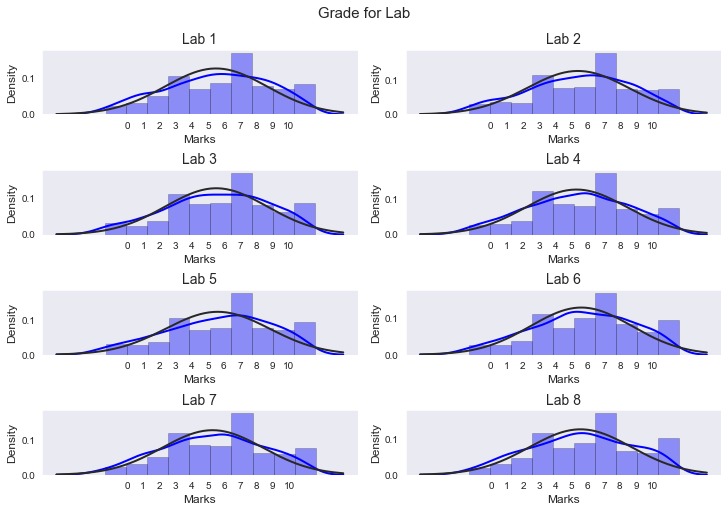

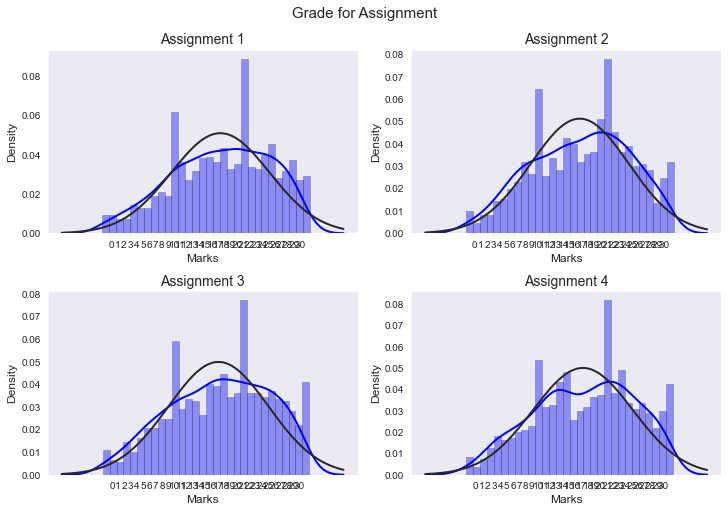

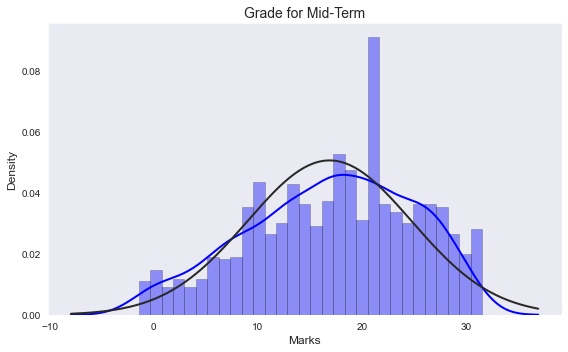

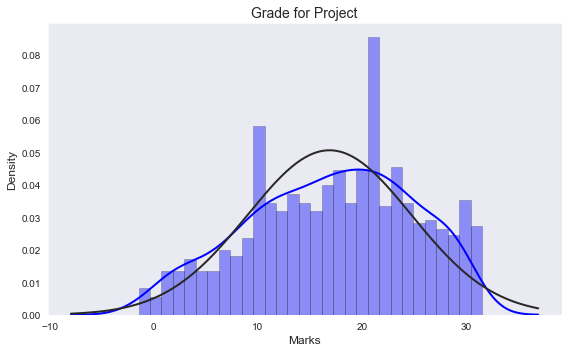

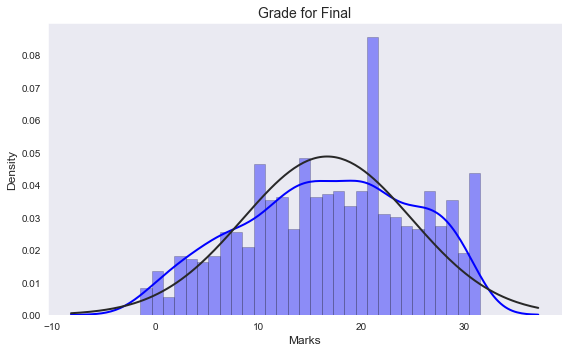

LogisticRegressionCV classifer
Accuracy -> 0.87
f1_score -> 0.8539325842696629

LinearRegression regressor
Accuracy -> 0.8428048073877803


In [8]:
passfail, overallgrade = grades(test_type, test_amount, max_mark, weightage, pass_percent, final_test_name)

#### Making models